# CSC413 Final Project


Alp Tarim, Mert Kaya, M. Rodin Karadeniz

## Introduction


For this project, we will be comparing the industry standard Natural Language Processing (NLP) methods:

- Recurrent Neural Network (RNN)
- Long Short-Term Memory (LSTM)
- Attention Network (with LSTM)
- Transformers

We will be comparing the computational cost, interpretability, and time complexities of each method by using them for the task of emotion detection.


## Setup PyTorch

### Setup Environment (if running in local environment)

Put your environment setup here. You can use `!conda ...` for conda environment installation, or `!pip ...` for pip environment installations


In [17]:
# code goes here
!pip install tokenizers
!pip install --upgrade transformers

     |████████████████████████████████| 4.0 MB 7.7 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchtext

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import re
import string
import os
import math

from typing import *

### Data

#### GoEmotions Setup

##### Download GoEmotions Dataset

In [ ]:
# Make sure you have wget installed with:
!pip install wget

!wget -nc -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -nc -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -nc -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f31b2a3d8b8c164a62eb60b1469c7cd2c46cdc53e23439cc16aa44d002d3b4f2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
--2022-04-23 02:11:06--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  --.-KB/s    in 0.1s    

2022-04-23 02:11:06 (96.8 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2022-04-23 02:11:06--  https://storage.googleapis.com/gresearch/goemotions/data/

##### Read GoEmotion CSVs

In [ ]:
EMOTIONS = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire',
            'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
            'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness',
            'surprise', 'neutral']

EMOTION_GROUPS = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"],
    "neutral": ["neutral"],
}


def read_goemotions(full_dataset_path: str) -> pd.DataFrame:
    used_cols = ['text'] + EMOTIONS

    DATA_GOEMOTIONS1_UNPROCESSED = pd.read_csv(
        f"{full_dataset_path}/goemotions_1.csv", usecols=used_cols, header=0)
    DATA_GOEMOTIONS2_UNPROCESSED = pd.read_csv(
        f"{full_dataset_path}/goemotions_1.csv", usecols=used_cols, header=0)
    DATA_GOEMOTIONS3_UNPROCESSED = pd.read_csv(
        f"{full_dataset_path}/goemotions_1.csv", usecols=used_cols, header=0)
    return pd.concat([DATA_GOEMOTIONS1_UNPROCESSED,
                      DATA_GOEMOTIONS2_UNPROCESSED,
                      DATA_GOEMOTIONS3_UNPROCESSED])


##### Process Emotions From File

In [ ]:
def process_goemotions_dataset(table: pd.DataFrame) -> pd.DataFrame:
    new_table = table.copy()

    categories = EMOTION_GROUPS.keys()
    category_indices = [i for i in range(len(categories))]
    
    for group in categories:
        new_table[group] = new_table.loc[:, EMOTION_GROUPS[group]].sum(axis=1)
        new_table[group] = (new_table[group] != 0).astype(int)
    
    sum_ = new_table.loc[:, categories].sum(axis=1)
    # print(sum_ > 1 | sum_ == 0)
    
    new_table = new_table.drop(new_table[((sum_ > 1) | (sum_ == 0))].index)
    
    new_table['emotion'] = new_table.loc[:, categories] @ category_indices

    emotion_not_category = [i for i in EMOTIONS if i not in categories]

    return new_table.drop(emotion_not_category, axis=1)

#### Filter, Tokenize, Pad the GoEmotions Text

This part of the implementation is based from GoEmotions [GitHub](https://github.com/google-research/google-research/tree/master/goemotions), specifically the [`extract_words.py`](https://github.com/google-research/google-research/blob/master/goemotions/extract_words.py) file.

THIS PART IS CURRENTLY USELESS IN THE PROJECT


In [ ]:
punct_chars = list((set(string.punctuation) | {
  "’", "‘", "–", "—", "~", "|", "“", "”", "…", "'", "`", "_",
  "“"
}) - set(["#"]))
punct_chars.sort()
punctuation = "".join(punct_chars)
replace = re.compile("[%s]" % re.escape(punctuation))


def clean_text(text):
    if isinstance(text, float):
        return []
    # lower case
    text = text.lower()
    # eliminate urls
    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text)
    # eliminate @mentions
    text = re.sub(r"\s@\S+", " ", text)
    # substitute all other punctuation with whitespace
    text = replace.sub(" ", text)
    # replace all whitespace with a single space
    text = re.sub(r"\s+", " ", text)
    # strip off spaces on either end
    text = text.strip()
    words = text.split()
    
    cleaned_text = [w for w in words if len(w) > 2]
    return "".join(cleaned_text)

def generate_vocab(unprocessed):
  # cleanup the text
  processed = unprocessed.copy()
  processed['text'] = processed['text'].apply(clean_text)

  # generate a vocabulary
  vocab = []
  def add_to_vocab(text):
    vocab.extend(text)

  processed['text'].apply(add_to_vocab)

  vocab = sorted(list(set(vocab)))
  len(vocab)
  vocab = dict((word, i) for i, word in enumerate(vocab))

#### Tokenization

In [ ]:
from tokenizers import Tokenizer, Encoding, models, normalizers, pre_tokenizers, decoders, trainers, processors


def train_tokenizer(data: pd.DataFrame) -> Tokenizer:
    tokenizer = Tokenizer(models.Unigram())
    tokenizer.normalizer = normalizers.BertNormalizer()
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
    tokenizer.post_processor = processors.ByteLevel()
    tokenizer.decoder = decoders.ByteLevel()

    trainer = trainers.UnigramTrainer(
        show_progress=True,
        initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
        special_tokens=["[PAD]"]
    )
    tokenizer.train_from_iterator(data.text.tolist(), trainer=trainer)

    tokenizer.enable_padding(
        pad_id=tokenizer.token_to_id("[PAD]"), pad_token="[PAD]")
    return tokenizer


def load_tokenizer() -> Tokenizer:
    return Tokenizer.from_file("data/tokenizer.json")


def save_tokenizer(tokenizer: Tokenizer):
    tokenizer.save("data/tokenizer.json")


def convert_encoding_to_ids(encoded: List[Encoding]) -> np.ndarray:
    return np.array([i.ids for i in encoded])


In [ ]:
def test_tokenizer():
  unprocessed = read_goemotions("data/full_dataset")
  data = process_goemotions_dataset(unprocessed)
  tokenizer = train_tokenizer(data)

  encoded_lst = tokenizer.encode_batch(["hello world 😘", "super"])
  encoded_ids = convert_encoding_to_ids(encoded_lst)
  print(encoded_ids.shape)

# test_tokenizer()
# TODO X: Turn the tokenized text into a useable torch.tensor (will be used as input) (batch size x sequence length x embedding dimension)
# TODO labels: Turn the parsed emotions into a useable torch.tensor (will be used as labels) (batch size x num emotions)
# TODO Create utility for "config" like in assignments to store hyperparameters and "dimensions"


### Utility

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def to_var(tensor, cuda):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

    Arguments:
        tensor: A Tensor object.
        cuda: A boolean flag indicating whether to use the GPU.

    Returns:
        A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def attr_dict_example_usage():
  rnn_args_s = AttrDict()
  args_dict = {
      "data_file_name": "pig_latin_small",
      "cuda": True,
      "nepochs": 50,
      "checkpoint_dir": "checkpoints",
      "learning_rate": 0.005,
      "lr_decay": 0.99,
      "early_stopping_patience": 20,
      "batch_size": 64,
      "hidden_size": 32,
      "encoder_type": "rnn",  # options: rnn / transformer
      "decoder_type": "rnn",  # options: rnn / rnn_attention / transformer
      "attention_type": "",   # options: additive / scaled_dot
  }
  rnn_args_s.update(args_dict)

## Recurrent Neural Network


In [ ]:
class EmoRNN(nn.Module):
    """ The Neural Network Model that involves RNN layers. Its architecture is as follows:
    * Embedding Layer (one-hot dim x embedding dim)
    * RNN Layer (embedding dim x hidden dim -> hidden dim*2 x hidden dim)
    * Linear Layer (hidden_dim x output dim)
    """

    def __init__(self, vocab_size, hidden_size, seq_len, num_emotions, num_layers=1, nonlinearity='tanh', batch_first=True, bidirectional=True):
        super(EmoRNN, self).__init__()

        # important dimensions
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.output_size = num_emotions
        self.seq_len = seq_len

        # setup the embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=hidden_size)

        # setup the RNN
        self.rnn = nn.RNN(
            input_size=self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,
            bias=False,
            batch_first=batch_first,
            bidirectional=bidirectional
        )

        self.D = 2 if bidirectional else 1

        self.classifier = nn.Linear(
            in_features=self.hidden_size * self.D * self.seq_len,
            out_features=self.output_size
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        # TODO: finish
        out = self.embedding(input)
        out, _ = self.rnn(out)
        out = self.classifier(
            out.reshape(-1, self.hidden_size*self.D*self.seq_len))
        out = self.softmax(out)
        # print(out.size())
        return out


# Long Short-Term Memory Neural Network

In [ ]:
class EmoLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, seq_len, num_emotions, num_layers=1, nonlinearity='tanh', batch_first=True, bidirectional=True):
        super(EmoLSTM, self).__init__()

        # important dimensions
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.output_size = num_emotions
        self.seq_len = seq_len

        # setup the embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=hidden_size)

        # setup the LSTM
        self.lstm = nn.LSTM(
            input_size=self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=num_layers,
            bias=False,
            batch_first=batch_first,
            bidirectional=bidirectional
        )

        self.D = 2 if bidirectional else 1

        self.classifier = nn.Linear(
            in_features=self.hidden_size * self.D * self.seq_len,
            out_features=self.output_size
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        out = self.embedding(input)
        out, _ = self.lstm(out)
        out = self.classifier(
            out.reshape(-1, self.hidden_size*self.D*self.seq_len))
        out = self.softmax(out)
        # print(out.size())
        return out

# Transformer

In [ ]:
from transformers import BertModel
import torch.nn as nn

class BertForSentenceClassification(BertModel):
    def __init__(self, config):
        super().__init__(config)
        
        ##### START YOUR CODE HERE #####
        # Add a linear classifier that map BERTs [CLS] token representation to the unnormalized
        # output probabilities for each class (logits).
        # Notes: 
        #  * See the documentation for torch.nn.Linear
        #  * You do not need to add a softmax, as this is included in the loss function
        #  * The size of BERTs token representation can be accessed at config.hidden_size
        #  * The number of output classes can be accessed at config.num_labels
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        ##### END YOUR CODE HERE #####
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, labels=None, **kwargs):
        outputs = super().forward(**kwargs)
        ##### START YOUR CODE HERE #####
        # Pass BERTs [CLS] token representation to this new classifier to produce the logits.
        # Notes:
        #  * The [CLS] token representation can be accessed at outputs.pooler_output
        logits = self.classifier(outputs.pooler_output)
        ##### END YOUR CODE HERE #####
        if labels is not None:
            outputs = (logits, self.loss(logits, labels))
        else:
            outputs = (logits,)
        return outputs

In [ ]:
from torch.optim import AdamW
import time
import datetime
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_optimizer_and_scheduler(model, total_steps, lr=2e-5, weight_decay=0.01):
    # Apply weight decay to all parameters beside the biases or LayerNorm weights
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay},
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        # Warmup learning rate for first 10% of training steps
        num_warmup_steps=int(0.10 * total_steps), 
        num_training_steps=total_steps,
    )
    return optimizer, scheduler

def train_model(model, epochs, train_dataloader, validation_dataloader):
    # Use GPU, if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Setup optimizer and LR scheduler 
    total_steps = len(train_dataloader) * epochs
    optimizer, scheduler = get_optimizer_and_scheduler(
        model, total_steps, lr=5e-5, weight_decay=0.01
    )

    loss_values = []
    eval_accs = []

    for epoch in range(0, epochs):
        t0 = time.time()

        total_loss = 0
        model.train()

        with tqdm(train_dataloader, unit="batch") as train_pbar:
            for batch in train_pbar:
                train_pbar.set_description(f"Training (epoch {epoch + 1})")
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # This will return the loss because we have provided the `labels`.
                outputs = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels
                )
                
                # The call to `model` always returns a tuple, so we need to pull the 
                # loss value out of the tuple.
                _, loss = outputs

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()

                # Update the learning rate.
                scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("  * Average training loss: {0:.2f}".format(avg_train_loss))
        print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
            
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask
                )
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_acc = eval_accuracy/nb_eval_steps
        print("  * Accuracy: {0:.2f}".format(avg_eval_acc))
        print("  * Validation took: {:}".format(format_time(time.time() - t0)))
        eval_accs.append(avg_eval_acc)
    print("Training complete!")
    return loss_values, eval_accs

# Pre-process and Training

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def log_info(info, args=[], verbose=True):
    if verbose:
        print(info, *args)


def get_d_labels(tokenizer: Tokenizer, data: pd.DataFrame, verbose=True):
    log_info("Getting inputs and labels from dataset...", verbose=verbose)
    log_info("\t getting batch from dataframe...", verbose=verbose)

    batch = data.text.tolist()

    log_info("\t encoding the batch...", verbose=verbose)

    encoded_lst = tokenizer.encode_batch(batch)

    log_info("\t converting Encoding objects to list of ids", verbose=verbose)

    encoded_ids = convert_encoding_to_ids(encoded_lst)

    log_info("\t getting labels from dataframe", verbose=verbose)

    labels = data.loc[:, EMOTION_GROUPS.keys()].to_numpy()
    return encoded_ids, labels


def train(opts):
  # TODO: move all the logs into function calls so the train function doesnt look ugly :)
    log_info("Reading dataset...", verbose=opts.verbose)
    unprocessed = read_goemotions("data/full_dataset")
    log_info("Preprocess dataset...", verbose=opts.verbose)
    data = process_goemotions_dataset(unprocessed)

    if opts.train_tokenizer:
        log_info("Training tokenizer...")
        tokenizer = train_tokenizer(data)
        save_tokenizer(tokenizer)
    else:
        log_info("Loading tokenizer...")
        tokenizer = load_tokenizer()

    d, labels = get_d_labels(tokenizer, data)

    dataset_size, seq_len = d.shape
    vocab_size = tokenizer.get_vocab_size()
    dataset_size_2, num_emotions = labels.shape
    
    d = torch.from_numpy(d)
    labels = torch.from_numpy(labels)

    assert dataset_size == dataset_size_2

    # model = EmoRNN(
    #     vocab_size=vocab_size,
    #     hidden_size=opts.hidden_size,
    #     seq_len=seq_len,
    #     num_emotions=num_emotions,
    # )

    model = EmoLSTM(
        vocab_size=vocab_size,
        hidden_size=opts.hidden_size,
        seq_len=seq_len,
        num_emotions=num_emotions,
    )

    # model = Net(
    #     TEXT.vocab.vectors,
    #     nhead=5,  # the number of heads in the multiheadattention models
    #     dim_feedforward=50,  # the dimension of the feedforward network model in nn.TransformerEncoder
    #     num_layers=6,
    #     dropout=0.0,
    #     classifier_dropout=0.0,
    # ).to(device)

    num_train = int(dataset_size * 0.8)
    num_validation = int((dataset_size-num_train) * 0.5)
    num_test = dataset_size - num_train - num_validation

    train_d, val_d, test_d = d[:num_train], \
        d[num_train:num_train + num_validation], \
        d[num_train+num_validation:]
    
    train_labels, val_labels, test_labels = labels[:num_train], \
        labels[num_train:num_train + num_validation], \
        labels[num_train+num_validation:]
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_d).type(
        torch.LongTensor), torch.tensor(train_labels).type(torch.LongTensor))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=opts.learning_rate)
    
    training_losses = []
    validation_losses = []
    test_losses = []
    
    training_accuracies = []
    validation_accuracies = []
    test_accuracies = []
    
    try:
      model.train()
      for epoch in range(opts.nepochs):
          print("----------------------------------------------------------------------------------")
          print(f"Epoch: {epoch}")
          
          running_loss = 0
          model.train()
          
          for sentences, labels in train_loader:
              # sentences, labels = sentences.to(device), labels.to(device)            
              optimizer.zero_grad()
              pred = model.forward(sentences)
              labels = labels.type(torch.FloatTensor)
              loss = criterion(pred, labels)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()
          else:
              model.eval() 
              # sentences, labels = sentences.to(device), labels.to(device)
              
              with torch.no_grad():
                  training_losses.append(running_loss/len(train_loader))
                  # training_accuracies.append(
                  #     torch.ceil(pred & labels).sum() / num_train)
                  
                  pred = model(val_d)
                  val_labels = val_labels.type(torch.FloatTensor)
                  validation_losses.append(criterion(pred, val_labels))
                  # validation_accuracies.append(
                  #     torch.ceil(pred & val_labels).sum() / num_validation)
                  
                  pred = model(test_d)
                  test_labels = test_labels.type(torch.FloatTensor)
                  test_losses.append(criterion(pred, test_labels))
                  # validation_accuracies.append(
                  #     torch.ceil(pred & test_labels).sum() / num_test)
              print(f"training loss: {training_losses[-1]}, validation loss: {validation_losses[-1]}, test loss: {test_losses[-1]}")
              # print(f"training accuracy: {training_accuracies[-1]}, validation accuracy: {validation_accuracies[-1]}, training accuracy: {test_accuracies[-1]}")
    except KeyboardInterrupt:
      print("Exiting early from training.")

    losses = [training_losses, validation_losses, test_losses]
    accuracies = [training_accuracies, validation_accuracies, test_accuracies]
    return model, losses, accuracies


In [ ]:
rnn_args_s = AttrDict()
args_dict = {
    "train_tokenizer": True,
    "hidden_size": 16,
    "learning_rate": 0.0001,
    "nepochs": 20,
    "verbose": True
}
rnn_args_s.update(args_dict)
model, losses, accuracies = train(rnn_args_s)
print(losses)
print(accuracies)

Reading dataset...
Preprocess dataset...
Training tokenizer...
Getting inputs and labels from dataset...
	 getting batch from dataframe...
	 encoding the batch...
	 converting Encoding objects to list of ids
	 getting labels from dataframe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


----------------------------------------------------------------------------------
Epoch: 0
training loss: 1.770966266055365, validation loss: 1.761897325515747, test loss: 1.7666378021240234
----------------------------------------------------------------------------------
Epoch: 1
training loss: 1.7619895000715513, validation loss: 1.7528631687164307, test loss: 1.7567628622055054
----------------------------------------------------------------------------------
Epoch: 2


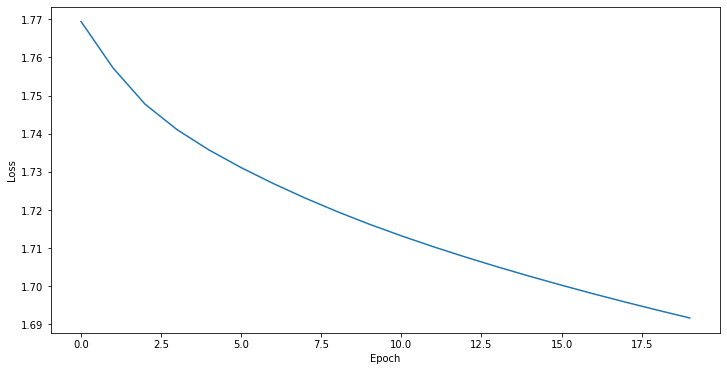

In [22]:
# Plot
plt.plot(losses[0], label = 'training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()